In [ ]:
!nvidia-smi

Fri Jul  8 15:17:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#從這開始是口罩辨識
#colab連接到GOOGLE Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#從Google Drive下載資料
! cp "/content/drive/MyDrive/AIDataset/medical-masks-dataset.zip" /content/

In [3]:
#資料解壓縮
! unzip /content/medical-masks-dataset.zip > data_unzip.log

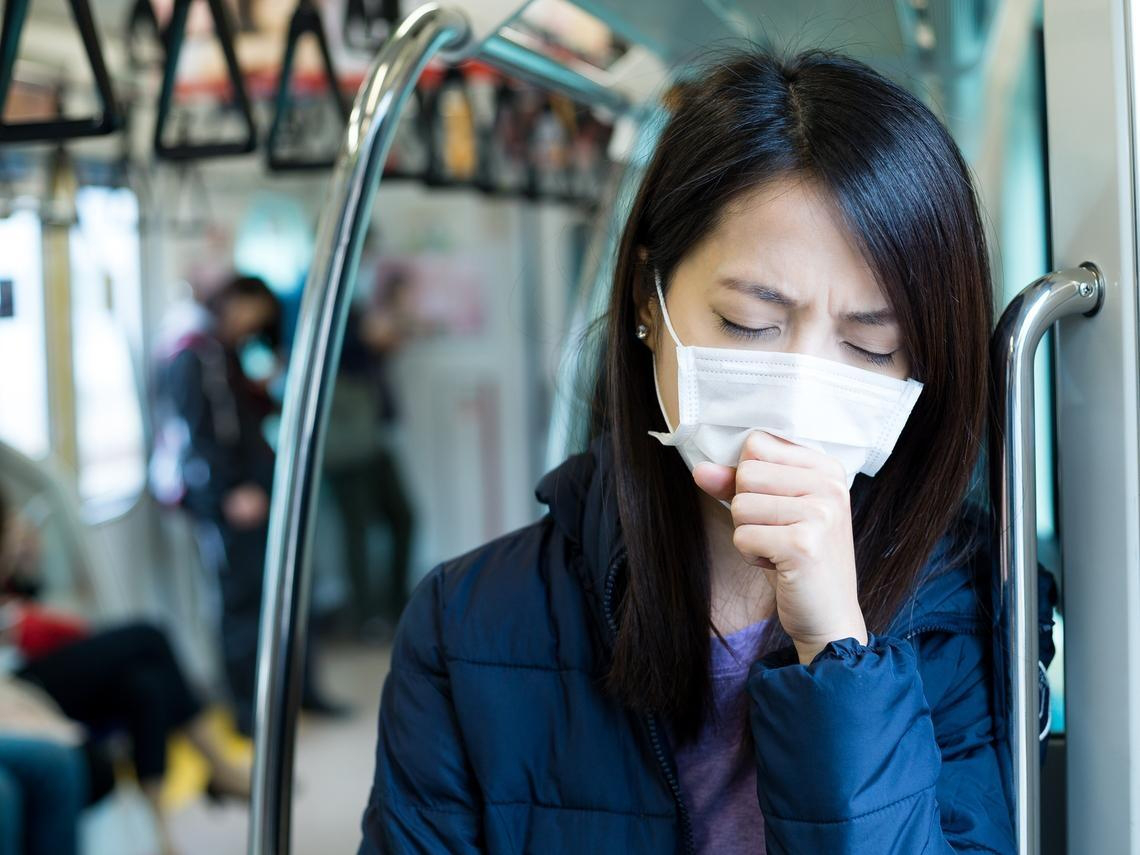

In [4]:
#查看照片
from PIL import Image
img = Image.open('/content/images/012106.jpg_1140x855.jpg')
img

In [5]:
#查看圖片對應的XML
! cat /content/labels/012106.jpg_1140x855.xml

<annotation>
	<folder>images</folder>
	<filename>012106.jpg_1140x855.jpg</filename>
	<path>P:\mask_mouth\images\012106.jpg_1140x855.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1140</width>
		<height>855</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>good</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>654</xmin>
			<ymin>275</ymin>
			<xmax>910</xmax>
			<ymax>517</ymax>
		</bndbox>
	</object>
</annotation>


In [6]:
#建立YOLO資料夾
! rm -rf /content/yolo
! mkdir /content/yolo

In [7]:
from bs4 import BeautifulSoup
import os
import shutil

#建置一個status_dic
status_dic ={'good':2,'bad':1,'none':0}

def getYoloFormat(filename,label_path, img_path, yolo_path, newname):
    with open(label_path+ filename, 'r') as f:
        #讀取xml
        soup =BeautifulSoup(f.read(),'xml')
        imgname =soup.select_one('filename').text
        image_w =int(soup.select_one('width').text)
        image_h =int(soup.select_one('height').text)
        ary=[]
        for obj in soup.select('object'):
            #取出xmin, xmax, ymin, ymax，並用status_dic轉換
            xmin =int(obj.select_one('xmin').text)
            xmax =int(obj.select_one('xmax').text)
            ymin =int(obj.select_one('ymin').text)
            ymax =int(obj.select_one('ymax').text)
            objclass =status_dic.get(obj.select_one('name').text)
            #轉成YOLO格式
            x= (xmin+(xmax-xmin)/2)*1.0 /image_w
            y= (ymin+(ymax-ymin)/2)*1.0 /image_h
            w= (xmax-xmin)*1.0 /image_w
            h= (ymax-ymin)*1.0 /image_h
            ary.append(' '.join([str(objclass), str(x),str(y),str(w),str(h)]))
        if os.path.exists(img_path + imgname):
            #把圖片移到yolo之下，同時把參數寫到yolo之下
            shutil.copyfile(img_path + imgname,yolo_path +newname + '.jpg')
            with open(yolo_path+newname+'.txt','w') as f:
              f.write('\n'.join(ary))

In [8]:
import os
#設定路徑
labelpath ='/content/labels/'
imgpath ='/content/images/'
yolopath ='/content/yolo/'
ary=[]
for idx, f in enumerate(os.listdir(labelpath)):
    try:
        #透過getYoloFromat將圖像爛參數檔寫到YOLO下
        getYoloFormat(f,labelpath,imgpath,yolopath,str(idx))
    except Exception as e:
        print(e)

float division by zero


In [9]:
from PIL import Image
import PIL
Image.open('/content/yolo/0.jpg')

Output hidden; open in https://colab.research.google.com to view.

In [10]:
#觀察對應的標記檔
! cat /content/yolo/0.txt

2 0.6067496409765438 0.47559224694903085 0.17376735280038297 0.28212491026561376
2 0.430828147438966 0.3621679827709978 0.14552417424605074 0.28212491026561376

準備訓練和測試資料集

In [11]:
#建立cfg_mask資料夾
! rm -rf /content/cfg_mask
! mkdir /content/cfg_mask

In [12]:
#/content/yolo/中從取出前80%的資料做為訓練資料
import os
datasets =['/content/yolo/'+f for f in os.listdir('/content/yolo/') if not f.endswith('.txt')]
len(datasets)*0.8

541.6

In [13]:
with open('/content/cfg_mask/train.txt', 'w') as f:
    #打開前80%的資料寫入train.txt
    f.write('\n'.join(datasets[0:540]))

In [14]:
with open('/content/cfg_mask/test.txt', 'w') as f:
    #打開後20%的資料寫入test.txt
    f.write('\n'.join(datasets[540:]))

In [15]:
! cp "/content/drive/My Drive/AIDataset/obj.data" cfg_mask/
! cp "/content/drive/My Drive/AIDataset/obj.names" cfg_mask/

In [16]:
! head /content/cfg_mask/obj.data
#三種class，訓練和測試資料集的路徑

classes= 3
train  = /content/cfg_mask/train.txt
valid  = /content/cfg_mask/test.txt
names  = /content/cfg_mask/obj.names
backup = /content/cfg_mask/weights/

In [17]:
! head /content/cfg_mask/train.txt

/content/yolo/645.jpg
/content/yolo/408.jpg
/content/yolo/560.jpg
/content/yolo/8.jpg
/content/yolo/707.jpg
/content/yolo/126.jpg
/content/yolo/518.jpg
/content/yolo/380.jpg
/content/yolo/668.jpg
/content/yolo/305.jpg


In [18]:
#觀察objname
! head /content/cfg_mask/obj.names

none
bad
good


In [19]:
#colab 中安裝pytorch
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 15 kB/s 
     |████████████████████████████████| 12.8 MB 41.1 MB/s 
     |████████████████████████████████| 7.6 MB 31.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.12.0+cu113
    Uninstalling torchaudio-0.12.0+cu113:
      Successfully uninstalled torchaudio-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

In [20]:
%cd '/content/drive/My Drive'
!git clone https://github.com/ultralytics/yolov5.git

/content/drive/My Drive
fatal: destination path 'yolov5' already exists and is not an empty directory.


In [21]:
#切换到yolov项目文件夹下，进行模型文件配置，pip命令安装requirements中的模块。
%cd '/content/drive/My Drive/yolov5'
!pip install -U -r requirements.txt # install dependencies

/content/drive/My Drive/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 25.9 MB/s 
     |████████████████████████████████| 60.9 MB 110 kB/s 
     |████████████████████████████████| 3.1 MB 58.8 MB/s 
     |████████████████████████████████| 596 kB 65.5 MB/s 
     |████████████████████████████████| 62 kB 1.9 MB/s 
     |████████████████████████████████| 750.6 MB 12 kB/s 
     |████████████████████████████████| 21.0 MB 227 kB/s 
     |████████████████████████████████| 407 kB 72.9 MB/s 
     |████████████████████████████████| 5.8 MB 54.8 MB/s 
     |████████████████████████████████| 793 kB 67.0 MB/s 
     |████████████████████████████████| 281 kB 77.0 MB/s 
     |████████████████████████████████| 944 kB 65.2 MB/s 
     |████████████████████████████████| 1.1 MB 69.8 MB/s 
     |████████████████████████████████| 381 kB 75.0 MB/s 
  Attempting uninstall: requests
    Found existing install

In [ ]:
#data.yaml的內容
#這邊不用執行
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../data  # dataset root dir
train: /content/cfg_mask/train.txt  # train images (relative to 'path') 128 images
val: /content/cfg_mask/test.txt  # val images (relative to 'path') 128 images
test: /content/cfg_mask/test.txt  # test images (optional)
 
# Classes
nc: 3 # number of classes
names: ['none','bad','good']  # class names


In [ ]:
%cd '/content/drive/My Drive/yolov5'

/content/drive/My Drive/yolov5


In [ ]:
%cd '/content/drive/My Drive/yolov5'

/content/drive/My Drive/yolov5


In [22]:
#訓練30epoch
!python train.py --epochs 30 --batch-size 16 --img 640 --data data/data.yaml --cfg models/yolov5m.yaml --weights runs/train/exp11/weights/

train: weights=runs/train/exp11/weights/, cfg=models/yolov5m.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch && git config --get remote.origin.url' timed out after 5 seconds
YOLOv5 🚀 v6.1-279-g36f64a9 Python-3.7.13 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, 

In [23]:
!python detect.py --weights /content/drive/MyDrive/yolov5/runs/train/exp10/weights/best.pt --img 640 --conf 0.25 --source /content/yolo/0.jpg

detect: weights=['/content/drive/MyDrive/yolov5/runs/train/exp10/weights/best.pt'], source=/content/yolo/0.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-279-g36f64a9 Python-3.7.13 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /content/yolo/0.jpg: 448x640 2 goods, Done. (0.025s)
Speed: 0.6ms pre-process, 25.3ms inference, 1.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp20


In [24]:
from PIL import Image
Image.open('/content/drive/MyDrive/yolov5/runs/detect/exp20/0.jpg')

Output hidden; open in https://colab.research.google.com to view.

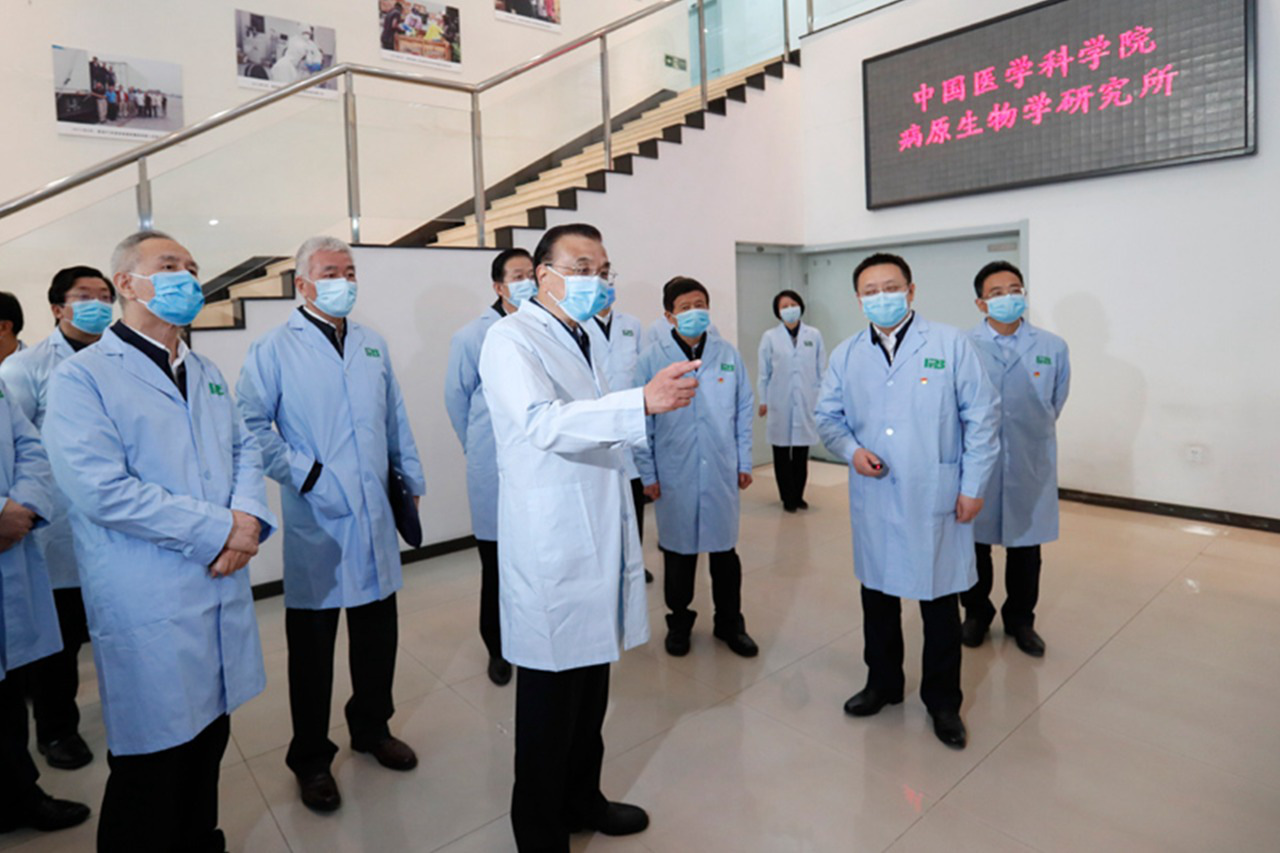

In [ ]:
from PIL import Image
Image.open('/content/yolo/254.jpg')

In [ ]:
!python detect.py --weights /content/drive/MyDrive/yolov5/runs/train/exp8/weights/best.pt --img 640 --conf 0.25 --source /content/yolo/254.jpg

detect: weights=['/content/drive/MyDrive/yolov5/runs/train/exp8/weights/best.pt'], source=/content/yolo/254.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-279-g36f64a9 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /content/yolo/254.jpg: 448x640 9 goods, Done. (0.022s)
Speed: 0.5ms pre-process, 21.9ms inference, 18.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp18


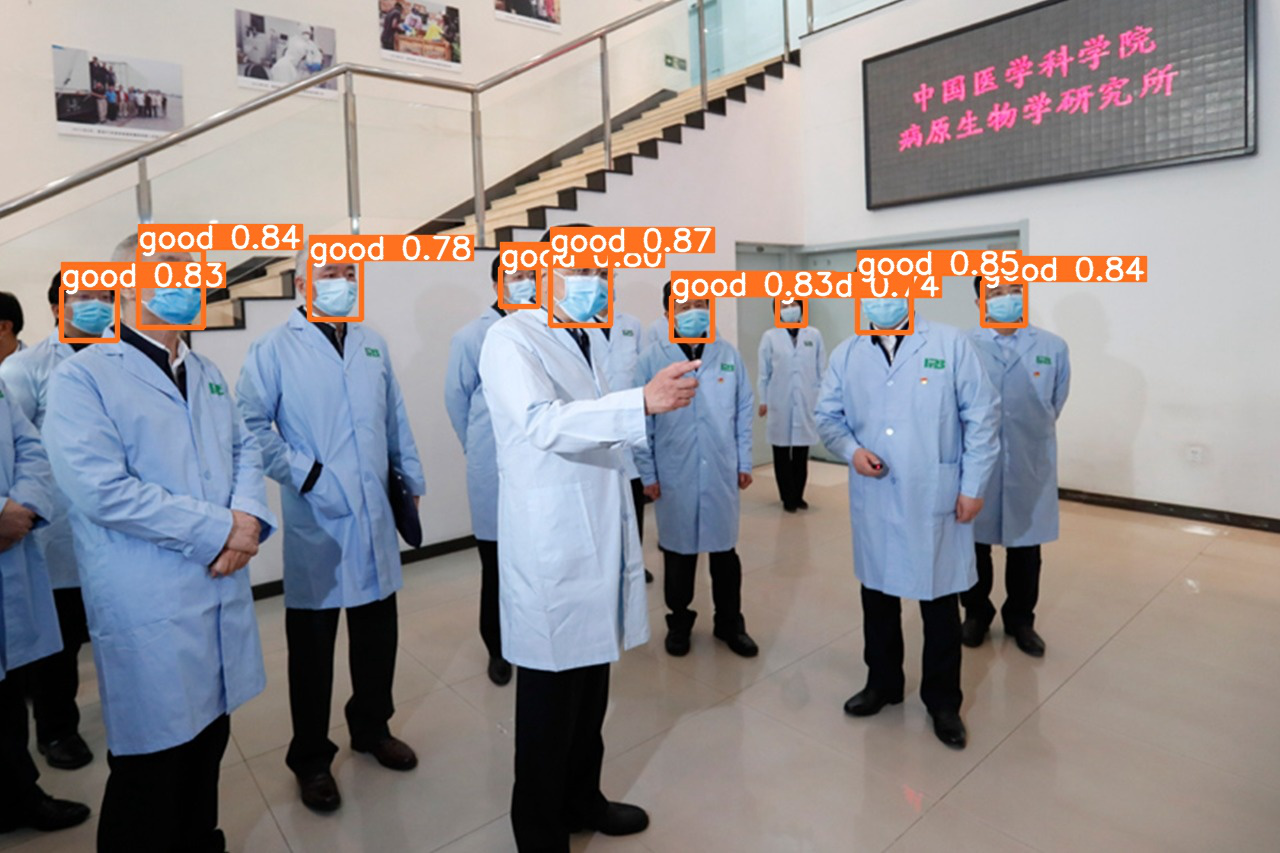

In [ ]:
from PIL import Image
Image.open('/content/drive/MyDrive/yolov5/runs/detect/exp18/254.jpg')

In [ ]:
from PIL import Image
Image.open('/content/yolo/10.jpg')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!python detect.py --weights /content/drive/MyDrive/yolov5/runs/train/exp8/weights/best.pt --img 640 --conf 0.25 --source /content/yolo/10.jpg

detect: weights=['/content/drive/MyDrive/yolov5/runs/train/exp8/weights/best.pt'], source=/content/yolo/10.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-279-g36f64a9 Python-3.7.13 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /content/yolo/10.jpg: 448x640 4 goods, Done. (0.025s)
Speed: 0.5ms pre-process, 25.3ms inference, 1.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp6


In [ ]:
from PIL import Image
Image.open('/content/drive/MyDrive/yolov5/runs/detect/exp6/10.jpg')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from PIL import Image
Image.open('/content/yolo/126.jpg')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!python detect.py --weights /content/drive/MyDrive/yolov5/runs/train/exp8/weights/best.pt --img 640 --conf 0.25 --source /content/yolo/126.jpg

detect: weights=['/content/drive/MyDrive/yolov5/runs/train/exp8/weights/best.pt'], source=/content/yolo/126.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-279-g36f64a9 Python-3.7.13 torch-1.11.0+cu102 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /content/yolo/126.jpg: 448x640 8 goods, Done. (0.025s)
Speed: 0.5ms pre-process, 25.3ms inference, 1.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp7
